# LIBRARIES

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from keras import layers
import matplotlib.image as img
import cv2

# DATA LOAD

Create a folder Output and create subfolders for train, test and validation.

In [31]:
# %pip install split-folders
import splitfolders
splitfolders.ratio('Dataset/', output="output", seed=145, ratio=(.8, 0.1,0.1)) 

Create "Dataset" objects in tensorflow for train/tset/validation

In [32]:
files = [os.path.join("./output/train/Non_Demented", file) for file in os.listdir("./output/train/Non_Demented") if file.endswith(('jpg','jpeg','png'))]
image = cv2.imread(files[0])
image_height = image.shape[0]
image_width = image.shape[1]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123, label_mode='categorical',
image_size=(image_height, image_width),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,label_mode='categorical',
image_size=(image_height, image_width),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,label_mode='categorical',
image_size=(image_height, image_width),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [33]:
print(image.shape)

(128, 128, 3)


In [34]:
class_names = train_ds.class_names
print(class_names)


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


# EXAMPLE IMAGE

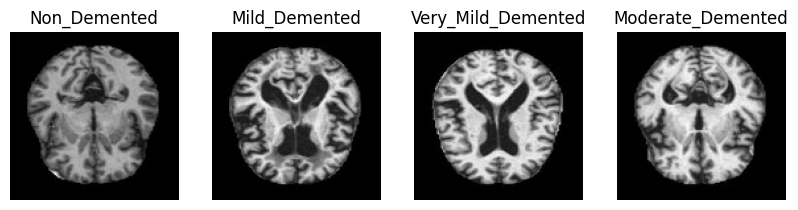

In [35]:
plt.figure(figsize=(10, 10))

        
index = 1
plotted = []

for images, labels in train_ds:
    for i in range(len(labels)):
        class_index = tf.argmax(labels[i]).numpy()
        class_name = class_names[class_index]
        if class_name not in plotted and index <= 4: 
            ax = plt.subplot(1, 4, index)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            plotted.append(class_name)
            index += 1
    if index > 4:  
        break
plt.show()     



In [36]:
size = {}

for folder in os.listdir('Dataset'):
    size[folder] = len(os.listdir(os.path.join('Dataset', folder)))

print(size)

{'Mild_Demented': 896, 'Moderate_Demented': 64, 'Non_Demented': 3200, 'Very_Mild_Demented': 2240}


<function matplotlib.pyplot.show(close=None, block=None)>

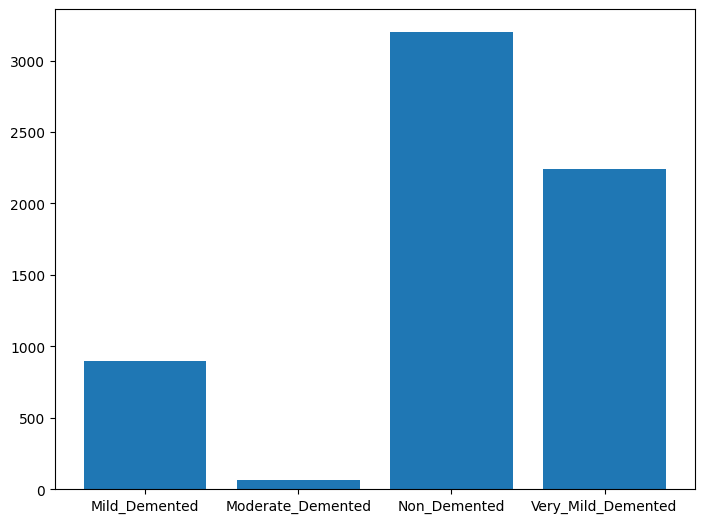

In [37]:

  
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(size.keys(),size.values())
plt.show

# MODEL

CNN is a neural network where nodes in one layer is connected to nodes in the next layer (not neccessarily all of them). It may contain some fully connected layers and the features learnt at each layer are non-linear combination of original features (using the method of kernel/filter) and then they go through the activation function for introducing non-linearity again so that they become differentiable at the time of optimization.

This is a 13 layer Neural network with layers and parameters follows:

Input layer - It does not perform any function on the input, it only acts as an interface and just passes the input to the first hidden layer through the weighted edge.

Rescaling - We rescale images to range [0,1] by dividing by 255 for efficient computation and consistency among features

Convolution layer - In this layer, we have used  3 x 3 kernel to extract feature maps with same padding to maintaine the size of the input image and avoid edge errors. RELU - Rectifyting linear unit used for introducing non linearity (outputs 0 if z < 0 and outputs z if z > 0>) to make it differentiable during optmization.

Max pooling layer - it is used to reduce the spatial dimensions of the features for efficient computation

Drop out layer - Introduces generalization and avoids overfitting by dropping a fraction input units randomly

Flatten layer - Flattens the input tensor into a 1D tensor. This prepares the data for input into the fully connected dense layers. It is done when we are almost ready to feed the data to output layer and stop convolution/forming new feature maps

The final output layer uses the softmax function which calculates the probabilities of the classes (such that they sum up to 1)  and the class with higher probability is the predicted class it belongs to.


In [39]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Rescaling, Dropout

cnn_model = Sequential()
cnn_model.add(Input((image_height,image_width, 3)))
cnn_model.add(Rescaling(1./255))
cnn_model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())

cnn_model.add(Dense(128,activation="relu",kernel_initializer="he_normal"))
cnn_model.add(Dense(32,"relu"))
cnn_model.add(Dense(4,"softmax"))

In [40]:
cnn_model.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=['accuracy',                                
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [41]:
filepath = './cnn_best_weights.keras'
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              patience=10,
                                              verbose=1)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,                           
                           verbose=1)

callbacks_list=[earlystopping,checkpoint]

In [42]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,124 (8.11 MB)

 Trainable params: 2,125,124 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# tf.keras.utils.plot_model(cnn_model,show_shapes=True,dpi=150)

In [45]:
train_val_hist = cnn_model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1,
                 callbacks= callbacks_list)

Epoch 1/50


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.4413 - loss: 1.5769 - precision: 0.4551 - recall: 0.3294
Epoch 1: val_accuracy improved from -inf to 0.50704, saving model to ./cnn_best_weights.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.4418 - loss: 1.5722 - precision: 0.4557 - recall: 0.3294 - val_accuracy: 0.5070 - val_loss: 1.0418 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5300 - loss: 0.9735 - precision: 0.6386 - recall: 0.3410
Epoch 2: val_accuracy improved from 0.50704 to 0.55243, saving model to ./cnn_best_weights.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.5301 - loss: 0.9733 - precision: 0.6387 - recall: 0.3412 - val_accuracy: 0.5524 - val_loss: 0.9353 - val_precision: 0.6825 - val_recall: 0.3365
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5625 - loss: 0.8943 - precision: 0.6789 - recall: 0.3875
Epoch 3: val_accuracy improved from 0.55243

# Plot the result


In [46]:
test_result = cnn_model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9905 - loss: 0.0442 - precision: 0.9905 - recall: 0.9905


In [48]:
test_loss = test_result[0]
test_accuracy = test_result[1]
test_precion = test_result[2]
test_recall = test_result[3]

print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy * 100 :.2f}%')
print(f'Test Precision = {test_precion}')
print(f'Test Recall = {test_recall}')

Test Loss = 0.04216046631336212
Test Accuracy = 99.22%
Test Precision = 0.9922118186950684
Test Recall = 0.9922118186950684


In [49]:
print(f'Test Accuracy = {test_accuracy * 100 :.2f}%')

Test Accuracy = 99.22%


In [52]:
get_ac = train_val_hist.history['accuracy']
get_los = train_val_hist.history['loss']
get_pre = train_val_hist.history['precision']
get_rec = train_val_hist.history['recall']
val_acc = train_val_hist.history['val_accuracy']
val_loss = train_val_hist.history['val_loss']

<Figure size 640x480 with 0 Axes>

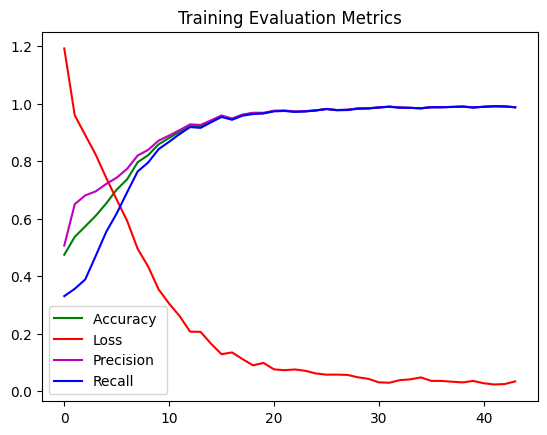

<Figure size 640x480 with 0 Axes>

In [53]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy ')
plt.plot(epochs, get_los, 'r', label='Loss')
plt.plot(epochs, get_pre, 'm', label='Precision')
plt.plot(epochs, get_rec, 'b', label='Recall')

plt.title('Training Evaluation Metrics')
plt.legend(loc=0)
plt.figure()



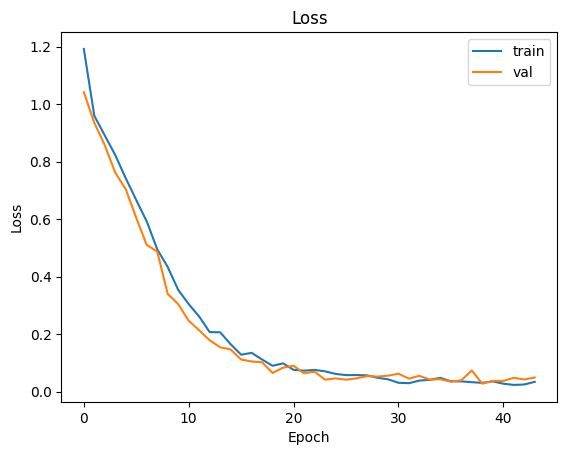

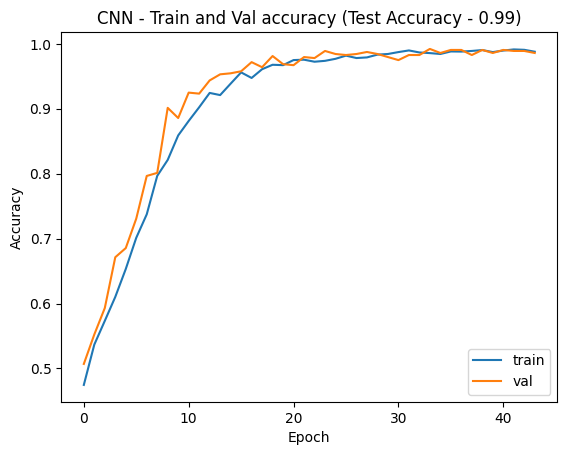

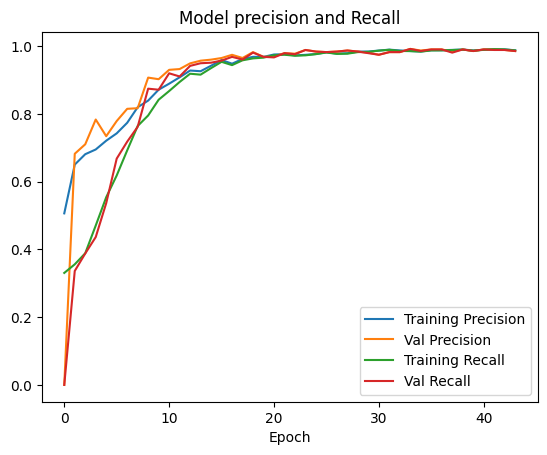

In [55]:
# loss
plt.plot(train_val_hist.history['loss'])
plt.plot(train_val_hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#Accuracy
plt.plot(train_val_hist.history['accuracy'])
plt.plot(train_val_hist.history['val_accuracy'])
plt.title('CNN - Train and Val accuracy (Test Accuracy - ' + str(format(test_result[1], "0.2f") + ')'))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

#Precision
plt.plot(train_val_hist.history['precision'], label = 'Training Precision')
plt.plot(train_val_hist.history['val_precision'],label = 'Val Precision')
plt.plot(train_val_hist.history['recall'], label = 'Training Recall')
plt.plot(train_val_hist.history['val_recall'], label = 'Val Recall')
plt.title('Model precision and Recall')

plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()



### Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


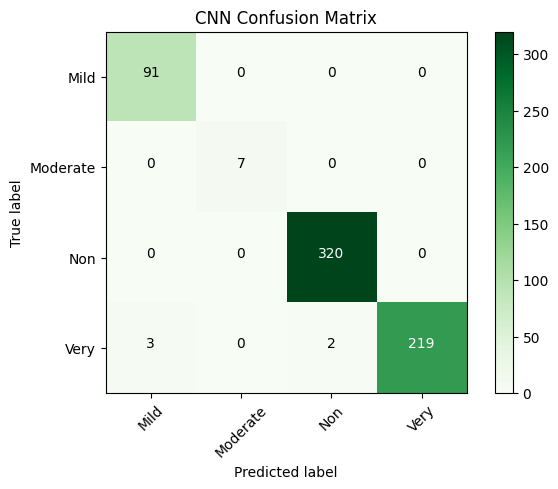

In [56]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = cnn_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('CNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
   
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

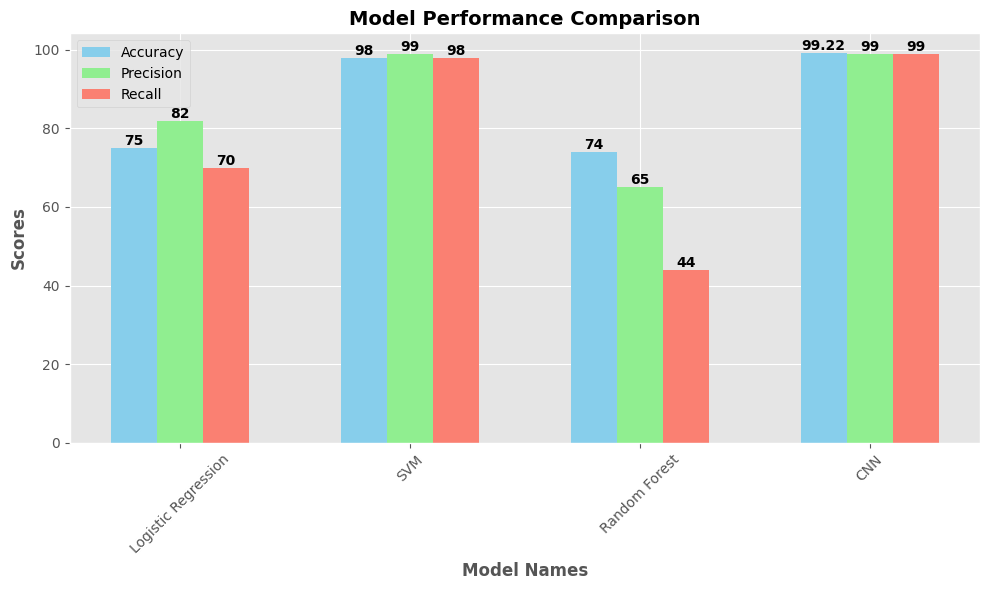

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Model': ["Logistic Regression", "SVM", "Random Forest", "CNN"],
    'Accuracy': [75, 98, 74, 99.22],
    'Precision': [82, 99, 65, 99],
    'Recall': [70, 98, 44, 99],
}

# Create DataFrame
df = pd.DataFrame.from_dict(data)
df.set_index('Model', inplace=True)

# Convert index to string type
df.index = df.index.astype(str)

# Set the style of the plots
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Define color combinations
accuracy_color = 'skyblue'
precision_color = 'lightgreen'
recall_color = 'salmon'

# Plot bars
bar_width = 0.2
index = range(len(df))
accuracy_bars = plt.bar(index, df['Accuracy'], bar_width, color=accuracy_color, label='Accuracy')
precision_bars = plt.bar([i + bar_width for i in index], df['Precision'], bar_width, color=precision_color, label='Precision')
recall_bars = plt.bar([i + 2 * bar_width for i in index], df['Recall'], bar_width, color=recall_color, label='Recall')

# Add labels and title
plt.xlabel('Model Names', fontsize=12, fontweight='bold')
plt.ylabel('Scores', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks([i + bar_width for i in index], df.index, rotation=45)
plt.legend()

# Show values on top of bars
def autolabel(bars, is_float=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if is_float and df.index[i] == 'CNN':
            plt.text(bar.get_x() + bar.get_width() / 2., height, '%.2f' % height, ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(bar.get_x() + bar.get_width() / 2., height, '%d' % int(height), ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(accuracy_bars, is_float=True)
autolabel(precision_bars)
autolabel(recall_bars)

plt.tight_layout()
plt.show()
